In [157]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset,DataLoader,ConcatDataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as T


from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from glob import glob as glob_module

In [158]:
import sys
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as mb
mb.set_matplotlib_formats('svg')

In [159]:
data_dir = r"C:\Users\ichigo7\Desktop\breast-cancer-hispathology-GAN\data\raw\kaggle_breast-hispathology-images"

transform = T.Compose([T.Resize((64, 64)), T.ToTensor()])
all_images = []
targets = []

# Using glob to get all PNG files recursively
png_files = glob_module(os.path.join(data_dir, '**', '*1.png'), recursive=True)  #only choosing class 1: with breast cancer

randIDX = np.random.choice(len(png_files), 20000, replace=False)

for idx in randIDX:
    img_path = png_files[idx]
    img = Image.open(img_path)
    label = int(os.path.basename(img_path)[-5]) 
    img = transform(img)
    all_images.append(img)
    targets.append(label)


all_images_tensor = torch.stack(all_images)
targets_tensor = torch.tensor(targets, dtype=torch.int64)  


dataset = TensorDataset(all_images_tensor, targets_tensor)

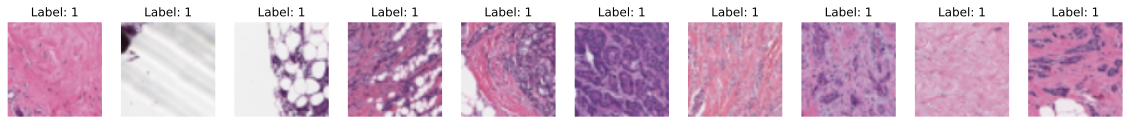

In [160]:
def show_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # permute to (H, W, C) for visualization
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

# Display 10 random images from the dataset
show_images(all_images_tensor, targets_tensor, num_images=10)

In [161]:
# Determine the number of samples for each class
result = {}
result[0]=0
result[1]=0
for image,label in dataset:
    label = label.item()
    result[label]+=1

print(f"Total Number of Images for each Class: "
     f"\n Class 0 (No Breast Cancer): {result[0]}"
     f"\n Class 1 (Breast Cancer present): {result[1]}")

Total Number of Images for each Class: 
 Class 0 (No Breast Cancer): 0
 Class 1 (Breast Cancer present): 20000


In [162]:
# transform to dataloaders
batchsize   = 100
data_loader = DataLoader(dataset,batch_size=batchsize,drop_last=True)

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [164]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output shape: torch.Size([10, 3, 64, 64])


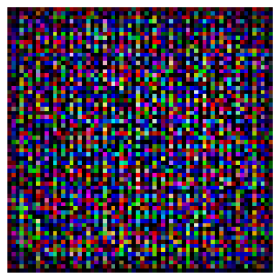

In [165]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gnet = generatorNet()
# Generate a batch of random noise vectors
noise = torch.randn(10, 100, 1, 1)  # Batch size of 10, with 100-dimensional noise vectors

# Pass the noise through the generator network
generated_images = gnet(noise)

# Print the shape of the output tensor
print("Output shape:", generated_images.shape)

# Visualize one of the generated images
plt.imshow(generated_images[0].permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()

In [166]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [167]:
# number of epochs (expressed in number of batches)
num_epochs = 12

losses  = []
disDecs = []

for epochi in range(num_epochs):

  for data,_ in data_loader:
    
    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])
    
    d1 = torch.mean((pred_real>.5).float()).detach()
    d2 = torch.mean((pred_fake>.5).float()).detach()
    disDecs.append([d1.cpu(),d2.cpu()])


  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)




Finished epoch 12/12

In [168]:
# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

In [169]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

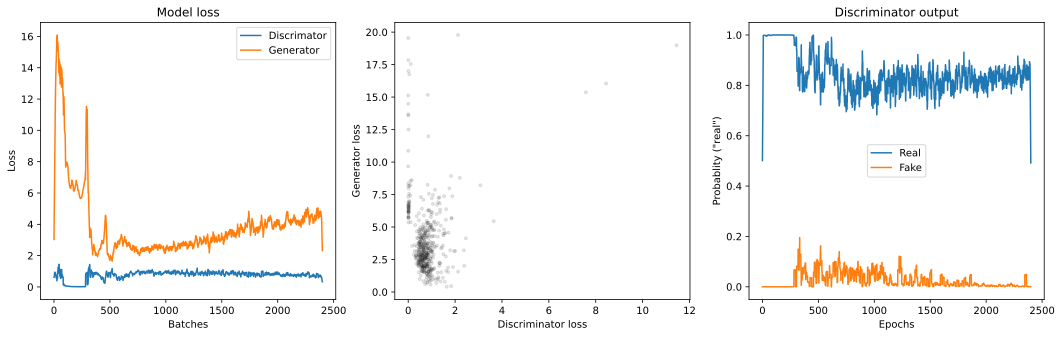

In [170]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,2300])
# ax[0].set_ylim([-.5,6])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


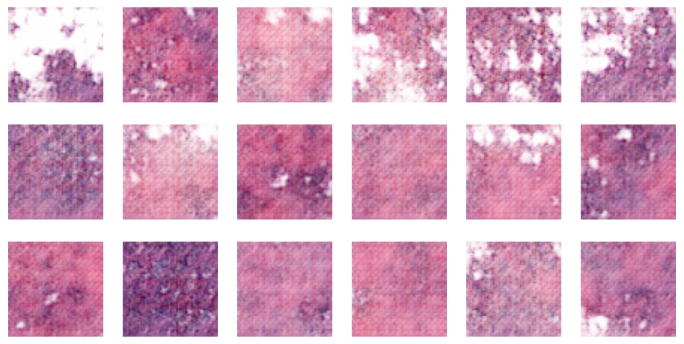

In [171]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i].detach().squeeze().permute(1, 2, 0))
  ax.axis('off')

plt.show()